In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
# Globals
NUM_CHANNELS = 3
RESOLUTION_LIST = [336] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-base-a-PrPo_Im-w-336-px-h-336-px/model'
IMAGE_SETS_SQUARE_TRAIN = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, train=True, rectangular = False)
IMAGE_SETS_SQUARE_TEST = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, train=False, rectangular = False)

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [7]:
trial_seed = 1
class_labels = getClassLabels("PrPo_Im")

training_images, training_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TRAIN[336]["PrPo_Im"])
test_images, test_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TEST[336]["PrPo_Im"])

In [3]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

Obtaining the class activation maps (CAM) and gradients from the three visualization techniques.

In [4]:
def grad_cam(index): 
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    probPrediction = [] # store probability of prediction by the CNN
    predictedClass = [] # store CNN-predicted class 
    # class_labels = getClassLabels("PrPo_Im")
    print("Observed image class: ", class_labels[np.argmax(test_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in test_labels[cam_img] ])]
        print(loss_list)
        probPrediction.append(str([np.round(max(softmax(loss)), 2) for loss in output.numpy()])[1:-1])
        predictedClass.append(class_labels[np.argmax([softmax(loss) for loss in output.numpy()])])
        print('Probability of prediction: ', probPrediction)
        print('Predicted class: ', predictedClass)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    print('Class labels: ', class_labels)
    
    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear # Assign linear activation function (pass-through) to the activation of layer at -1
        return model
    
    gradcam_image = np.squeeze(test_images[cam_img])
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) # Penultimate layer is a fully-connected hidden layer. 
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print(gradcam_image.shape)
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, probPrediction, predictedClass

In [9]:
grad_cam([18])

Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-6.3495016  6.1313453]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=6.1313453>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([3.7987056e-06, 9.9999619e-01], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


(array([[0.        , 0.01611088, 0.03222176, ..., 0.13353507, 0.15517512,
         0.17681521],
        [0.02171849, 0.03724958, 0.05278067, ..., 0.13618329, 0.15825252,
         0.18032175],
        [0.04343699, 0.05838829, 0.07333959, ..., 0.1388315 , 0.1613299 ,
         0.18382828],
        ...,
        [0.22869052, 0.24517429, 0.2616581 , ..., 0.20019263, 0.21502711,
         0.2298616 ],
        [0.22537221, 0.24288654, 0.26040086, ..., 0.16091998, 0.17819402,
         0.19546805],
        [0.22205393, 0.24059878, 0.25914362, ..., 0.12164732, 0.14136091,
         0.1610745 ]], dtype=float32),
 array([[[0.83921569, 0.88627451, 0.94901961],
         [0.84705882, 0.89411765, 0.95686275],
         [0.85098039, 0.89803922, 0.96078431],
         ...,
         [0.18039216, 0.20392157, 0.09411765],
         [0.2       , 0.22745098, 0.11372549],
         [0.19215686, 0.21568627, 0.09803922]],
 
        [[0.84313725, 0.88627451, 0.95686275],
         [0.84705882, 0.89019608, 0.96078431],
 

In [10]:
def guided_backprop(index, activation_layer):
    # Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=jgTRCYgX4oz-&line=1&uniqifier=1  
#     print(validation_images[index].shape)
    backprop_image = validation_images[index].reshape(1, 336, 336, 3)
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    model = models.load_model(FULL_MODEL_PATH) # set model inside the function
    modified_model = models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(activation_layer).output]
    )
    layer_dict = [layer for layer in modified_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(backprop_image, tf.float32)
        tape.watch(inputs)
        outputs = modified_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    return grads

In [11]:
guided_backprop(18, 'conv2d_4')

<tf.Tensor: shape=(336, 336, 3), dtype=float32, numpy=
array([[[-0.05228716, -0.02835044,  0.00055187],
        [ 0.00425439, -0.03895349, -0.01700349],
        [-0.06379902,  0.00288076,  0.08405203],
        ...,
        [ 0.00866143,  0.02983328, -0.0195885 ],
        [ 0.00675074, -0.02314286, -0.02226038],
        [ 0.01627066,  0.00982996, -0.01493348]],

       [[-0.03804548, -0.07113059,  0.0185797 ],
        [ 0.0072543 , -0.02588139,  0.02993681],
        [-0.03759428, -0.02905055,  0.06226103],
        ...,
        [ 0.02592257,  0.03321344, -0.00361611],
        [-0.03676745,  0.01526763,  0.00801999],
        [ 0.00314422, -0.00204447, -0.00527968]],

       [[ 0.0235341 , -0.02210061, -0.02248274],
        [ 0.04277924, -0.0298451 ,  0.03985093],
        [ 0.04708485,  0.06729779,  0.08174711],
        ...,
        [ 0.00583698,  0.05939538,  0.04178141],
        [-0.00078341,  0.03408653,  0.00795274],
        [ 0.01175035, -0.00453527, -0.01157015]],

       ...,

     

In [8]:
def guided_gradcam(index, activation_layer='conv2d_4'): #normalize=False
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    gbp  = guided_backprop([index], activation_layer)
    gcam = grad_cam([index])[0]
#     if normalize:
#         gbp = deprocess_image(np.array(np.squeeze(gbp)))
#     else:
#         gbp = np.squeeze(gbp)
    
    ggcam = gbp * gcam[..., np.newaxis]
#     print(gcam[..., np.newaxis])
    print('Shape of GGCAM: ', ggcam.shape)
    return ggcam

In [137]:
guided_gradcam(18, 'conv2d_4')

Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-4.8984175  2.22506  ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.22506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([8.053103e-04, 9.991947e-01], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336, 3)


<tf.Tensor: shape=(336, 336, 3), dtype=float32, numpy=
array([[[ 0.01075589,  0.00128931,  0.00031308],
        [ 0.00790303,  0.00118333, -0.00791927],
        [ 0.00318857, -0.00192625,  0.01308455],
        ...,
        [ 0.00037807,  0.00623193, -0.00259549],
        [ 0.00502877,  0.00577903,  0.0019054 ],
        [-0.00151092,  0.00290248, -0.00249943]],

       [[ 0.00073553,  0.01370886, -0.00455309],
        [-0.00034775,  0.0049612 , -0.00288147],
        [ 0.00593804,  0.01451414,  0.01189206],
        ...,
        [ 0.00523   ,  0.00745202, -0.00012535],
        [ 0.00027313,  0.00383977,  0.00155092],
        [ 0.00256832,  0.00408382,  0.00091936]],

       [[-0.00164837, -0.0022404 ,  0.0089643 ],
        [ 0.01939918,  0.00286272, -0.00452862],
        [ 0.02040532,  0.01065382,  0.03217786],
        ...,
        [ 0.00439429,  0.0021485 ,  0.00583943],
        [ 0.01027314,  0.00486088,  0.0006105 ],
        [ 0.00884039, -0.00121717, -0.00361064]],

       ...,

     

Visually rendering the outputs of the three functions and the original image from the validation set.

In [14]:
def renderOriginal(index, save=False, grid=False, c_map='gist_gray'):
    '''Plot the original image found in the validation set.'''
    originals_dir = '../../figures/plottingOriginals/'
    print('Observation: ',class_labels[np.argmax(validation_labels[index])])
    if grid==False:
        standardizePlot(index, originals_dir, 'Original Image (validation) in '+ c_map)
        plt.imshow(np.squeeze(validation_images[index]), cmap=c_map)
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(np.squeeze(validation_images[index]), cmap=c_map)
    if save:
        plt.savefig(originals_dir+'original-'+str(index)+'-'+c_map+'.jpg')
    return validation_images[index]

Observation:  Improbable


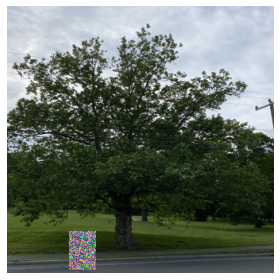

In [18]:
ro = renderOriginal(20, False, True)

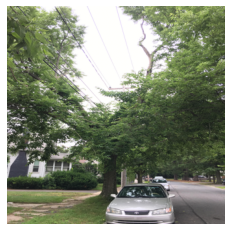

In [17]:
plt.axis('off')
plt.imshow(np.squeeze(validation_images[18]), cmap='gist_gray')

In [8]:
def renderGradCam(index, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing gradient-weighted class activation maps as an overlay (heatmap) to the original image.'''
    gradcam_dir = '../../figures/plottingGradCam/'
    gcam = grad_cam([index])
    # class_labels = getClassLabels("PrPo_Im")
    
    if grid==False:
        plt.figure(figsize=(5, 5))
        # plt.suptitle('Grad-CAM Index '+str(index)[1:-1]+'\n')
        plt.title('Observed class: '+class_labels[np.argmax(test_labels[index])], y=-0.08)
        plt.text(-0.7,-0.05, "Probability of prediction: "+ str("{:.0%}".format(float(str(gcam[2])[2:-2])))+'\n', size=12)
        plt.text(-0.7,-0.35, 'Predicted class: '+ str(gcam[3])[2:-2], size=12)
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map) # remove axes of length one from gradcam_images
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
    else:
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map)
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5)
    # print(gradcam_dir+"gradcam-"+str(index)[1:-1])
    if save:
        if not os.path.exists(gradcam_dir):
            os.makedirs(gradcam_dir)
        plt.savefig(gradcam_dir+"gradcam-"+str(index)+".png")
    return (heatmap)

Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 3.775401  -3.7740984]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.775401>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([9.9947387e-01, 5.2609650e-04], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


array([[[  0,   0, 141],
        [  0,   0, 141],
        [  0,   0, 136],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]],

       [[  0,   0, 141],
        [  0,   0, 136],
        [  0,   0, 136],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]],

       [[  0,   0, 136],
        [  0,   0, 136],
        [  0,   0, 136],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]],

       ...,

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]]

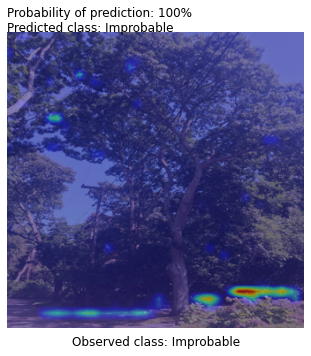

In [9]:
renderGradCam(25, True, False)

In [11]:
def renderGBP(index, activation_layer='conv2d_4', save=False, grid=False, c_map='gist_gray'): #normalize=False
    '''Visualizing Guided Backpropagation with an option to use normalized gradients.'''
    gbp = deprocess_image(np.squeeze(guided_backprop([index], activation_layer)))
    gbp_dir = '../../figures/plottingBackProp/'
    
    # Deprocessing is applied regardless of normalization. Therefore commenting out this case for both GB and Guided GCAM.
    #if normalize: 
    #    save_name = gbp_dir+"guided_backprop-"+str(index)+'-normalized-'+c_map+".png"
    #    gbp = deprocess_image(np.squeeze(gbp))
    #else:
    #    save_name = gbp_dir+"guided_backprop-"+str(index)+'-'+c_map+".png"
    #    gbp = np.squeeze(gbp)
        
    if grid:
        plt.axis('off')
        plt.tight_layout()
#         plt.imshow(np.flip(gbp, -1), cmap=c_map) 
    else:
        standardizePlot(index, gbp_dir, 'Guided Backpropagation')    
        
    plt.imshow(np.flip(gbp, -1), cmap=c_map) # Reverse the order of elements, starting from the last axis, in order to compute saliency.
    
    if save:
        save_name = gbp_dir+"guided_backprop-"+str(index)+'-'+c_map+".png"
        plt.savefig(save_name)
    return (gbp)

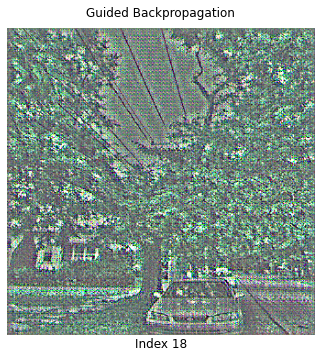

In [12]:
gbp1 = renderGBP(18, 'conv2d_4', False, False)

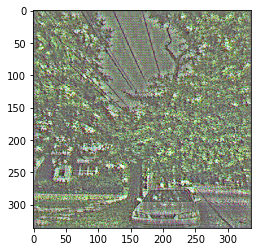

In [50]:
plt.imshow(np.squeeze(gbp1))

In [13]:
def renderGGCAM(index, activation_layer='conv2d_4', save=False, grid = False, c_map='gist_gray'): #normalize=False,
    '''Visualizing Guided Grad-CAM output with an option to use normalized guided backpropagation gradients.'''
    ggcam_dir = '../../figures/plottingGuided-GradCam/'
    plot_name = ''
    ggcam = deprocess_image(np.squeeze(guided_gradcam(index, activation_layer)))
    
    #if normalize:
    #    plot_name = "guided-gradcam-"+str(index)+'-'+c_map+'-normalized.png'
    #    ggcam = deprocess_image(ggcam)
    #    print('Using normalized GBP gradients...')
    #else:
    #    plot_name = "guided-gradcam-"+str(index)+'-'+c_map+".png"
    
    if grid:
        plt.axis('off')
        plt.tight_layout()
#         plt.imshow(np.flip(ggcam, -1), cmap=c_map) 
    else:
        standardizePlot(index, ggcam_dir, 'Guided Grad-CAM')
        
    plt.imshow(np.flip(ggcam, -1), cmap=c_map) # Reverse the order of elements, starting from the last axis, in order to compute saliency.   
    
    if save:
        plot_name = "guided-gradcam-"+str(index)+'-'+c_map+".png"
        plt.savefig(ggcam_dir+plot_name)
        print('Saving '+plot_name+' in '+ggcam_dir)
        
    return(ggcam)

Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336, 3)


array([[[116, 117, 123],
        [119,  97, 110],
        [126, 126, 123],
        ...,
        [116, 138, 113],
        [129, 121, 132],
        [113, 113, 106]],

       [[116, 126, 110],
        [101, 112, 101],
        [131, 146, 117],
        ...,
        [118, 124, 132],
        [133, 130, 130],
        [110, 106, 122]],

       [[121, 120, 115],
        [133, 102, 128],
        [122, 128, 144],
        ...,
        [146, 115, 100],
        [138, 139, 106],
        [107,  89,  90]],

       ...,

       [[104, 110, 104],
        [116, 135, 141],
        [141, 171, 180],
        ...,
        [101,  96, 122],
        [126, 113, 125],
        [110, 108, 118]],

       [[102, 104,  83],
        [109, 112, 128],
        [137, 132, 112],
        ...,
        [119, 117, 121],
        [117, 126, 133],
        [131, 130, 128]],

       [[104, 120, 103],
        [114, 127, 115],
        [141, 116, 101],
        ...,
        [120, 120, 106],
        [108, 111, 109],
        [113, 114, 119]]

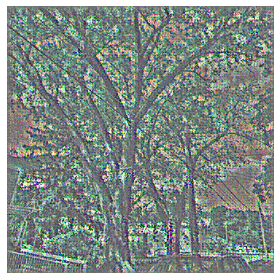

In [14]:
renderGGCAM(15, 'conv2d_4', False, True)

In [15]:
def plotVisualizations(index, activation_layer='conv2d_4', c_map='gist_gray', save=False):
    subplot_args = { 'nrows': 1, 'ncols': 4, 'figsize': (15, 15), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }
    grid_dir = '../../figures/'
    plot_name = 'plot_grid_'+str(index)
    f, axs = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    axis_labels = ['Processed Input', 'GradCAM', 'Guided Backprop', 'Guided GradCAM']
    orig_image = validation_images[index]
    gcam_heatmap = renderGradCam(index, False, True)    
    gbp = renderGBP(index, activation_layer, False, True)
    ggcam = renderGGCAM(index, activation_layer, False, True)
    f.suptitle('Observed: ' + class_labels[np.argmax(validation_labels[index])]+ '. Predicted: ' + str(grad_cam([index])[3])[2:-2]+'. Probability: '+str("{:.0%}".format(float(str(grad_cam([index])[2])[2:-2])))+'.', y=0.595, fontsize=24, va='bottom') 
    axs[0].imshow(np.squeeze(orig_image))
    axs[1].imshow(np.squeeze(orig_image))
    axs[1].imshow(gcam_heatmap, cmap=c_map, alpha=0.5)
    axs[2].imshow(gbp, cmap=c_map)
    axs[3].imshow(ggcam, cmap=c_map)
    for axis in f.axes:
        axis.set_axis_on()
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["left"].set_visible(False)
        axis.spines["bottom"].set_visible(False)        
    for i, axis in enumerate(f.axes):
        axis.set_xlabel(axis_labels[i], fontsize=18)
    f.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        f.savefig(grid_dir+plot_name, bbox_inches='tight')
        print('Saving '+plot_name+' in '+grid_dir)
    return 

Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336, 3)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dty

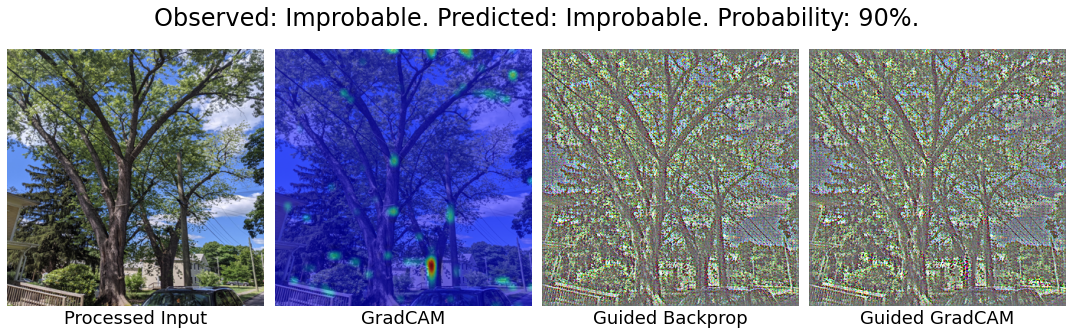

In [16]:
plotVisualizations(18, 'conv2d_4', 'gist_gray', False)